In [1]:
 %matplotlib notebook

# Analysis

Notebook containing code to create our plots

In [2]:
import pandas as pd
from tqdm.autonotebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

plt.style.use(['science', 'notebook'])

/tmp/ipykernel_49363/3720026528.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Preambula
We are going to run some computations, to save time let's create a decorator that stores and read from disk

In [3]:
def maybe_load_from_disk(location: Path):
    def decorator(func):
        def _inner(*args, **kwargs):
            if location.exists():
                print(f"[INFO] loading from {location}")
                with open(location, "rb") as f:
                    return pickle.load(f)
            res = func(*args, **kwargs)
            with open(location, "wb") as f:
                print(f"[INFO] saving to {location}")
                pickle.dump(res, f)
            return res
        return _inner
    return decorator
    

In [4]:
df = pd.read_csv("categories.csv", index_col=0)

df.head()

,category
dataset,
hand-gestures-jps7z,real world
smoke-uvylj,real world
wall-damage,real world
corrosion-bi3q3,real world
excavators-czvg9,real world


# Sizes

Find out total dataset sizes, we have `rf100` download at `rf100`. We can use the index to iterate and get the size of each folder

In [5]:
from pathlib import Path
from functools import reduce
from collections import defaultdict

RF100_ROOT = Path('./rf100')

def count_num_files(dataset: str):
    dataset_path = RF100_ROOT / dataset
    sub_dirs = ["train", "valid", "test"]
    num_files = defaultdict(int)
    for sub_dir in sub_dirs:
        sub_dir_path = dataset_path / sub_dir / 'images'
        num_files[sub_dir] += sum([1 if curr.is_file() else 0 for curr in sub_dir_path.iterdir()])
    
    return pd.Series(num_files)

In [6]:
@maybe_load_from_disk(Path('./df.pkl'))
def apply_num_files(df):
    df[["train", "test", "valid"]] = df.apply(lambda row: count_num_files(row.name), axis=1)[["train", "test", "valid"]]
    df["size"] = df["train"] +  df["test"] +  df["valid"]
    return df

df = apply_num_files(df)

[INFO] loading from df.pkl


Let's see how many of them there are for each category

In [7]:
grouped_df = df.groupby("category").sum("size").reset_index()
grouped_df = grouped_df.sort_values("size")
grouped_df["perc"] = grouped_df["size"] / grouped_df["size"].sum()
grouped_df

,category,train,test,valid,size,perc
0,aerial,6643,1100,1940,9683,0.043112
6,videogames,8233,1127,2219,11579,0.051554
3,microscopic,9576,1273,2529,13378,0.059564
5,underwater,12595,1794,3570,17959,0.079960
1,documents,17866,2350,4597,24813,0.110476
2,electromagnetic,25398,3669,7314,36381,0.161981
4,real world,77885,10952,21970,110807,0.493353


Now, we want to use the order of the categories to sort our original dataframe, till will make it easier to visualize them

In [8]:
df_with_ordered_categories = pd.DataFrame(index=grouped_df.index, data={"category": grouped_df.category})
df = df_with_ordered_categories.merge(df.reset_index("dataset"), on="category", how="inner")
df = df.set_index("dataset")
df

,category,train,test,valid,size
dataset,,,,,
aerial-pool,aerial,673,96,177,946
secondary-chains,aerial,103,16,43,162
aerial-spheres,aerial,318,51,104,473
soccer-players-5fuqs,aerial,114,16,33,163
weed-crop-aerial,aerial,823,118,235,1176
...,...,...,...,...,...
bees-jt5in,real world,5640,836,1604,8080
sedimentary-features-9eosf,real world,156,21,45,222
currency-v4f8j,real world,576,82,155,813


## Bounding boxes stats

Cool, so we may also want to plot/show the mean size of bboxes for each dataset

Let's create something to read all the annotations. We can take advantage of PyTorch Dataloader to use multiple cores and make the computation go brum brum

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch

IGNORE = -1
# all images are resized to 640
size = (640, 640)

class AnnotationDataset(Dataset):
    def __init__(self, root: Path, fmt: str = "txt"):
        super().__init__()
        self.annotations_paths = list(root.glob(f"**/*.{fmt}"))
    
    def maybe_convert_polygon_to_bbox(self, line: str):
        splitted = line.split(" ")
        label, rest = splitted[0], splitted[1:]
        label = torch.as_tensor(int(label))
        is_bbox = len(rest) == 4
        if is_bbox:
            return  label, torch.as_tensor([float(el) for el in rest])
        else:
            # must be a polygon
            poly = torch.as_tensor([float(el) for el in rest])
            poly = poly.view(-1, 2)
            xmax, ymax = torch.max(poly, dim=0).values
            xmin, ymin = torch.min(poly, dim=0).values
            width, heigh = xmax - xmin, ymax - ymin
            xcenter, ycenter =  xmin + width / 2, ymin + heigh / 2
            return label, torch.stack([xcenter, ycenter, width, heigh])
            
    def __getitem__(self, idx: int):
        with self.annotations_paths[idx].open('r') as f:
            for line in f.readlines():
                label, bbox = self.maybe_convert_polygon_to_bbox(line)
                return label, bbox 
            return  torch.tensor(IGNORE), torch.as_tensor([IGNORE, IGNORE, IGNORE, IGNORE], dtype=torch.float32)
        
    def __len__(self):
        return len(self.annotations_paths)

Let's try it out

In [10]:
ds = AnnotationDataset(RF100_ROOT / df.index[0] / 'test' / 'labels')
ds[0]

(tensor(5), tensor([0.3250, 0.1555, 0.0320, 0.1305]))

gg. Now we can use a torch `DataLoader` to speed up stuff. Let's define a couple of functions to help us out

In [151]:
def get_areas_and_labels(dataset: str, split: str ="test"):
    ds = AnnotationDataset(RF100_ROOT / dataset / split / 'labels')
    dl = DataLoader(ds, num_workers=8, batch_size=128)

    all_areas = None
    all_labels = None
    for (labels, bboxes) in dl:
        bboxes = bboxes[labels != IGNORE] 
        # area = w * h
        areas = bboxes[:,2] * bboxes[:,3]
        all_areas = torch.cat((all_areas, areas)) if all_areas is not None else areas
        all_labels = torch.cat((all_labels, labels)) if all_labels is not None else labels

    return all_areas, all_labels


def compute_stats(areas: torch.Tensor):
    # let's compute the number of small, medium and large bbox
    bins = torch.histc(areas, bins=3, min=0, max=0.3)
    return areas.mean(), areas.std(), *bins

In [152]:
@maybe_load_from_disk(Path("./bbox.pkl"))
def create_bbox_df(df):
    records = []
    dataset_bar = tqdm(df.index)
    for dataset in dataset_bar:
        dataset_bar.set_postfix_str(dataset)
        split_bar = tqdm(["train", "test", "valid"], leave=False)
        for split in split_bar:
            split_bar.set_postfix_str(split)
            areas, labels = get_areas_and_labels(dataset, split)
            vals = compute_stats(areas)
            vals = [val.float().item() for val in vals]
            area_mean, area_std, num_small, num_medium, num_large = vals
            labels = labels[labels != IGNORE]
            records.append(dict(
                                num_classes=labels.unique().numpy().shape[0],
                                labels=labels.unique().numpy(),
                                areas=areas.numpy(),
                                area_mean=area_mean, 
                                area_std=area_std, 
                                num_small=num_small, 
                                num_medium=num_medium, 
                                num_large=num_large,
                                split=split,
                                dataset=dataset,
                            )
                          )

    return pd.DataFrame.from_records(records)

In [153]:
bbox_df = create_bbox_df(df)
bbox_df

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] saving to bbox.pkl


,num_classes,labels,areas,area_mean,area_std,num_small,num_medium,num_large,split,dataset
0,6,"[0, 1, 2, 3, 5, 6]","[0.0021484375, 0.0026550293, 0.00021362305, 0....",0.006654,0.011052,663.0,2.0,0.0,train,aerial-pool
1,5,"[0, 2, 3, 5, 6]","[0.004179077, 0.019511718, 0.0030212402, 0.004...",0.009999,0.011440,93.0,0.0,0.0,test,aerial-pool
2,7,"[0, 1, 2, 3, 4, 5, 6]","[0.0065325922, 0.0002636719, 0.00033203125, 0....",0.009365,0.015438,172.0,1.0,0.0,valid,aerial-pool
3,1,[0],"[0.16773254, 0.0037487794, 0.006408691, 0.0082...",0.029541,0.044291,95.0,7.0,1.0,train,secondary-chains
4,1,[0],"[0.002546997, 0.010966186, 0.108736575, 0.0135...",0.053974,0.071981,13.0,2.0,1.0,test,secondary-chains
...,...,...,...,...,...,...,...,...,...,...
295,2,"[0, 1]","[0.403584, 0.08379272, 0.025009155, 0.03186645...",0.120005,0.115028,78.0,19.0,22.0,test,trail-camera
296,2,"[0, 1]","[0.04377685, 0.19937013, 0.022744752, 0.004980...",0.117687,0.134675,145.0,41.0,27.0,valid,trail-camera
297,2,"[0, 1]","[0.006101074, 0.03232361, 0.0041357423, 0.0210...",0.011733,0.012671,679.0,0.0,0.0,train,cell-towers
298,2,"[0, 1]","[0.013339234, 0.005393066, 0.028710939, 0.0036...",0.009002,0.007607,95.0,0.0,0.0,test,cell-towers


In [154]:
train_df = bbox_df[bbox_df["split"] == "train"].reset_index(drop=True)
valid_df = bbox_df[bbox_df["split"] == "valid"].reset_index(drop=True)
test_df = bbox_df[bbox_df["split"] == "test"].reset_index(drop=True)

In [155]:
train_df

,num_classes,labels,areas,area_mean,area_std,num_small,num_medium,num_large,split,dataset
0,6,"[0, 1, 2, 3, 5, 6]","[0.0021484375, 0.0026550293, 0.00021362305, 0....",0.006654,0.011052,663.0,2.0,0.0,train,aerial-pool
1,1,[0],"[0.16773254, 0.0037487794, 0.006408691, 0.0082...",0.029541,0.044291,95.0,7.0,1.0,train,secondary-chains
2,5,"[0, 2, 3, 4, 5]","[0.00062988285, 0.0006036377, 0.0006036377, 0....",0.000619,0.000080,318.0,0.0,0.0,train,aerial-spheres
3,1,[1],"[0.007775879, 0.004264526, 0.0026489256, 0.006...",0.005348,0.001906,114.0,0.0,0.0,train,soccer-players-5fuqs
4,2,"[0, 1]","[0.00072265626, 0.0010070801, 0.002351074, 0.0...",0.003095,0.008399,822.0,1.0,0.0,train,weed-crop-aerial
...,...,...,...,...,...,...,...,...,...,...
95,1,[0],"[0.005355835, 0.00090820313, 0.00109375, 0.008...",0.005481,0.006934,4747.0,1.0,0.0,train,bees-jt5in
96,5,"[0, 1, 2, 3, 4]","[0.0021679688, 0.007305908, 0.0029882814, 0.00...",0.008032,0.005847,149.0,0.0,0.0,train,sedimentary-features-9eosf
97,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0.07074777, 0.003942871, 0.032546997, 0.02666...",0.210679,0.279003,256.0,127.0,70.0,train,currency-v4f8j
98,2,"[0, 1]","[0.08338623, 0.03020874, 0.037950438, 0.023263...",0.112492,0.124287,579.0,153.0,117.0,train,trail-camera


In [197]:
import numpy as np 

all_missing_labels = []
all_is_correct = []
for idx, (train_labels, valid_labels, test_labels) in tqdm(
                                zip(train_df.index,
                                    zip(train_df["labels"].values,  valid_df["labels"].values,  test_df["labels"].values
                                       )
                                   ),
                                total=len(train_df)):
    # see https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html
    missing_from_valid = np.setdiff1d(valid_labels, train_labels)
    missing_from_test = np.setdiff1d(test_labels, train_labels)
    missing_labels = np.array([])
    
    if missing_from_valid.shape[0] > 0:
        missing_labels = np.concatenate((missing_labels, missing_from_valid))
    if missing_from_test.shape[0] > 0:
        missing_labels = np.concatenate((missing_labels, missing_from_test))
    
    is_correct = missing_labels.shape[0] == 0
    all_missing_labels.append(missing_labels)
    all_is_correct.append(is_correct)

train_df["missing_labels"] = all_missing_labels
train_df["is_correct"] = all_is_correct


  0%|          | 0/100 [00:00<?, ?it/s]

In [198]:
train_df

,num_classes,labels,areas,area_mean,area_std,num_small,num_medium,num_large,split,dataset,missing_labels,is_correct
0,6,"[0, 1, 2, 3, 5, 6]","[0.0021484375, 0.0026550293, 0.00021362305, 0....",0.006654,0.011052,663.0,2.0,0.0,train,aerial-pool,[4.0],False
1,1,[0],"[0.16773254, 0.0037487794, 0.006408691, 0.0082...",0.029541,0.044291,95.0,7.0,1.0,train,secondary-chains,[],True
2,5,"[0, 2, 3, 4, 5]","[0.00062988285, 0.0006036377, 0.0006036377, 0....",0.000619,0.000080,318.0,0.0,0.0,train,aerial-spheres,[],True
3,1,[1],"[0.007775879, 0.004264526, 0.0026489256, 0.006...",0.005348,0.001906,114.0,0.0,0.0,train,soccer-players-5fuqs,[],True
4,2,"[0, 1]","[0.00072265626, 0.0010070801, 0.002351074, 0.0...",0.003095,0.008399,822.0,1.0,0.0,train,weed-crop-aerial,[],True
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,[0],"[0.005355835, 0.00090820313, 0.00109375, 0.008...",0.005481,0.006934,4747.0,1.0,0.0,train,bees-jt5in,[],True
96,5,"[0, 1, 2, 3, 4]","[0.0021679688, 0.007305908, 0.0029882814, 0.00...",0.008032,0.005847,149.0,0.0,0.0,train,sedimentary-features-9eosf,[],True
97,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0.07074777, 0.003942871, 0.032546997, 0.02666...",0.210679,0.279003,256.0,127.0,70.0,train,currency-v4f8j,[],True
98,2,"[0, 1]","[0.08338623, 0.03020874, 0.037950438, 0.023263...",0.112492,0.124287,579.0,153.0,117.0,train,trail-camera,[],True


In [203]:
wrong_df = train_df[~train_df["is_correct"]]

In [205]:
wrong_df[["dataset", "missing_labels"]].to_csv("missing.csv")

Let's add all the prev informations

In [35]:
df = df.join(bbox_df)

In [ ]:
df[""]

<IPython.core.display.Javascript object>


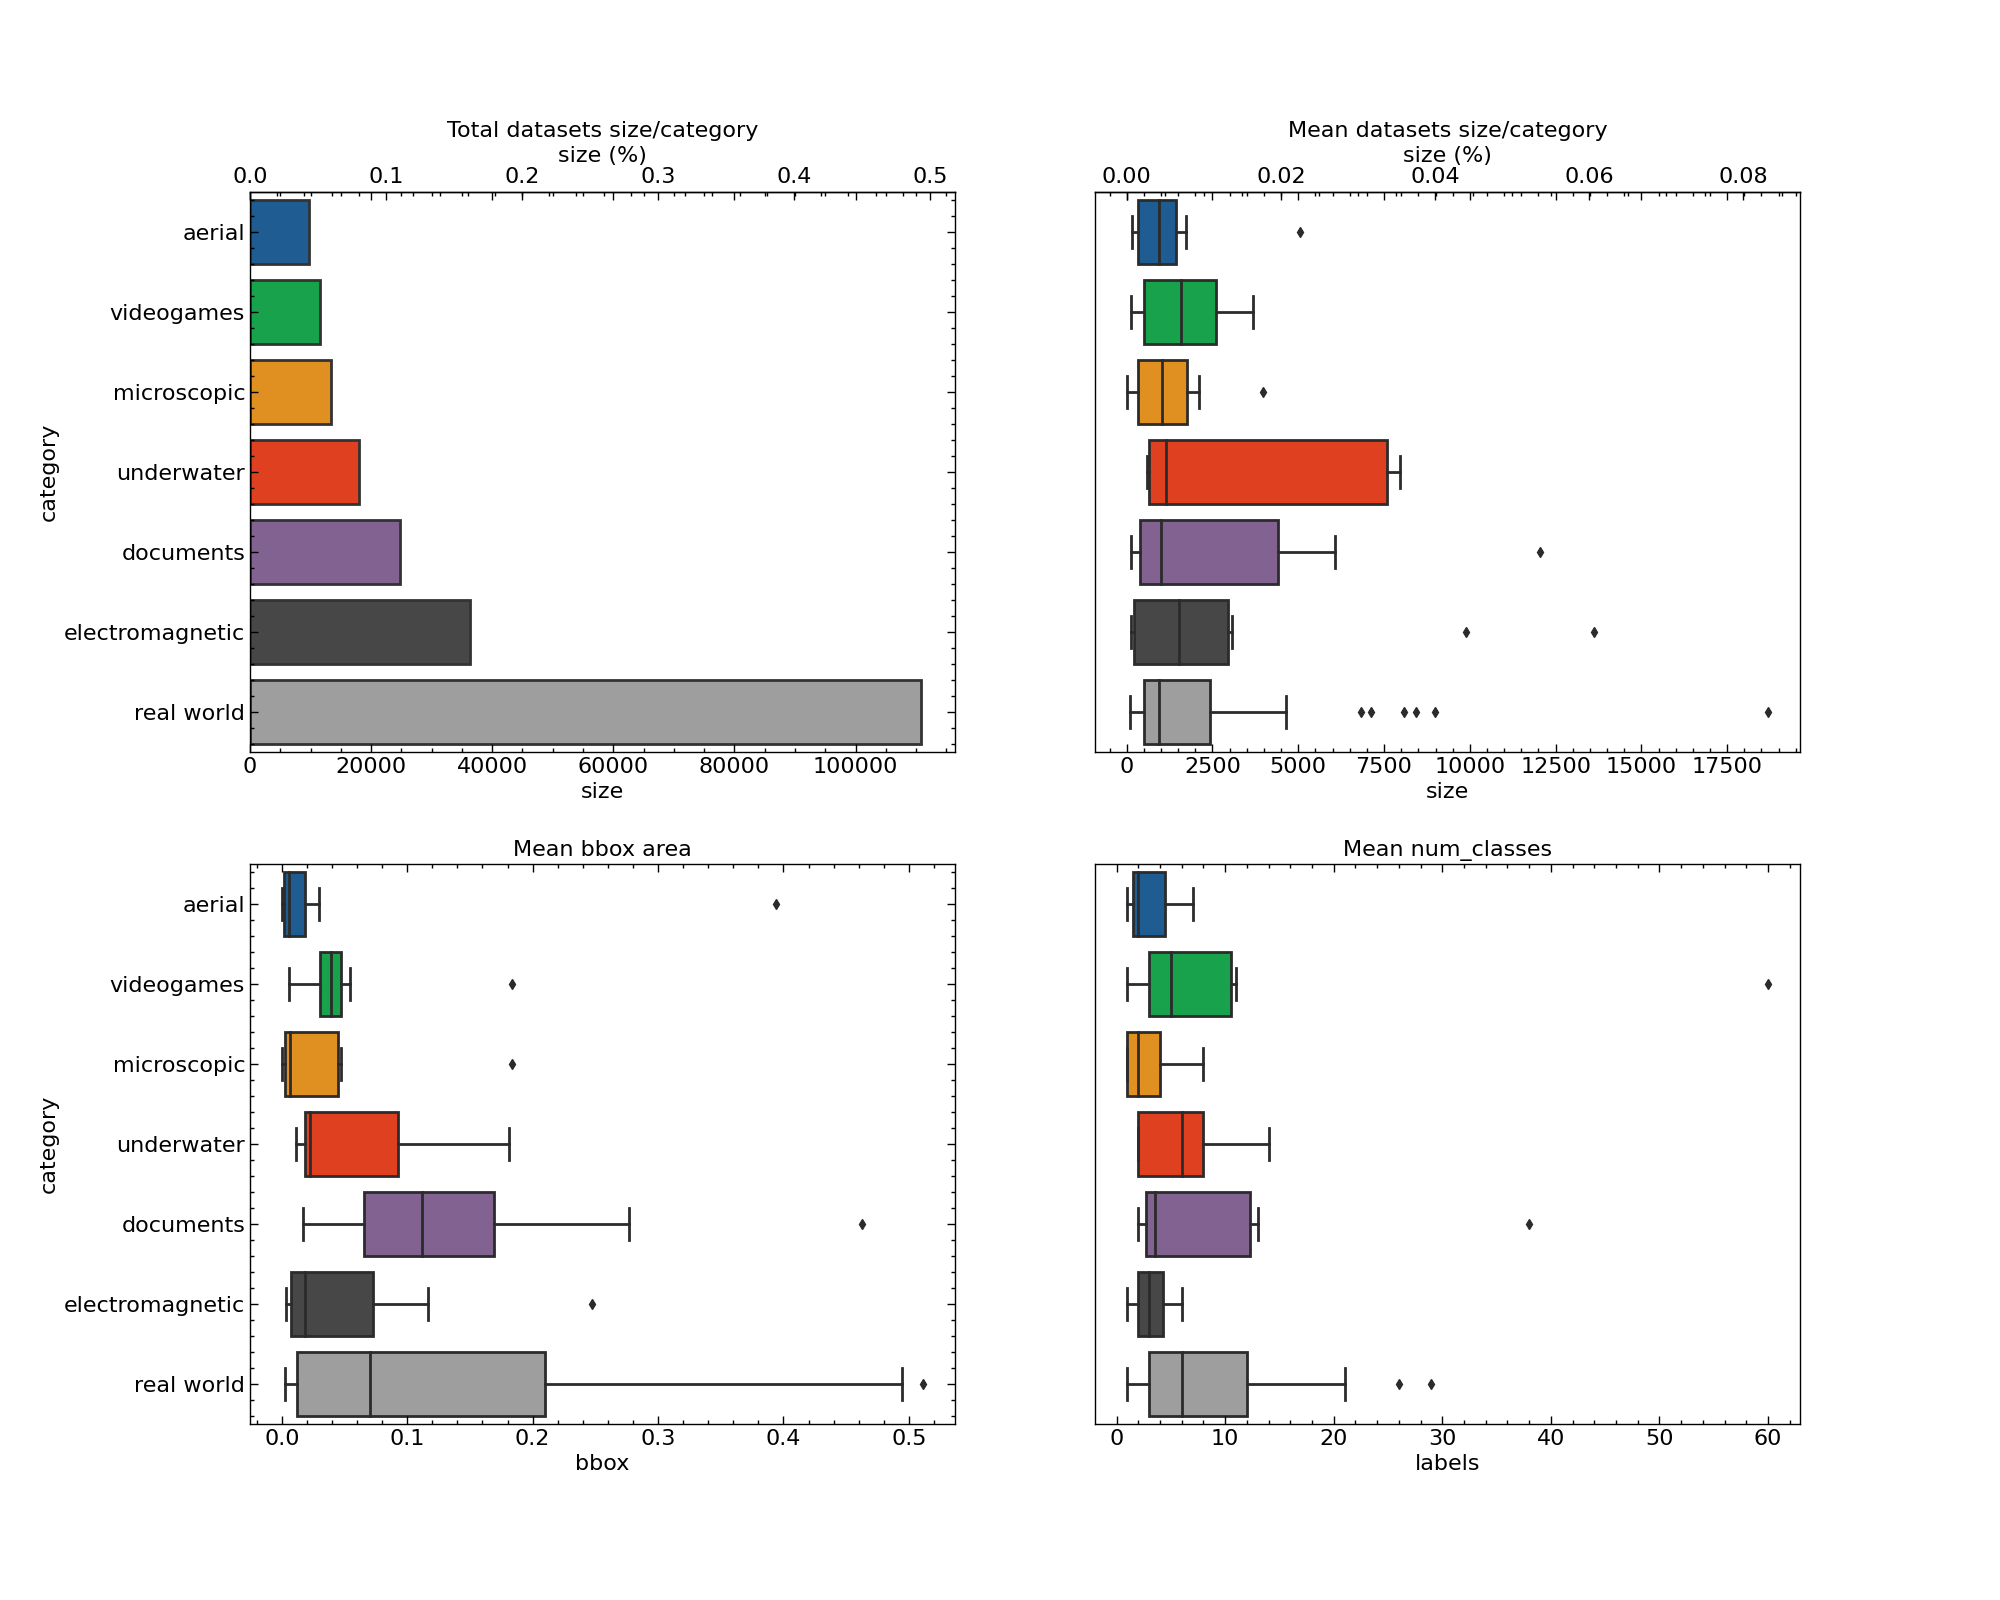

In [44]:
fig, axs = plt.subplots(2, 2,  figsize=(20,16))
# fig.suptitle('Datasets Categories')
axs[0,0].set_title("Total datasets size/category")
ax = sns.barplot(data=grouped_df, x="size", y="category", linewidth=2,  edgecolor=".2", ax=axs[0,0])
ax.set_ylabel('category')
ax.set_xlabel('size')
secax = ax.secondary_xaxis('top', functions=(lambda x: x / grouped_df["size"].sum(), lambda x:x))
secax.set_xlabel('size (%)')
ax.minorticks_on()
secax.minorticks_on()

axs[0,1].set_title("Mean datasets size/category")
ax = sns.boxplot(data=df, x="size", y="category", ax=axs[0,1])
ax.set_xlabel('size')
ax.get_yaxis().set_visible(False)
secax = ax.secondary_xaxis('top', functions=(lambda x: x / grouped_df["size"].sum(), lambda x:x))
secax.set_xlabel('size (%)')
ax.minorticks_on()
secax.minorticks_on()

axs[1,0].set_title("Mean bbox area")
ax = sns.boxplot(data=df, x="area_mean", y="category", ax=axs[1,0])
ax.set_xlabel("bbox")

axs[1,1].set_title("Mean num_classes")
ax = sns.boxplot(data=df, x="num_classes", y="category", ax=axs[1,1])
ax.set_xlabel("labels")
ax.get_yaxis().set_visible(False)

In [45]:
plt.savefig("datasets_train.png")

<IPython.core.display.Javascript object>


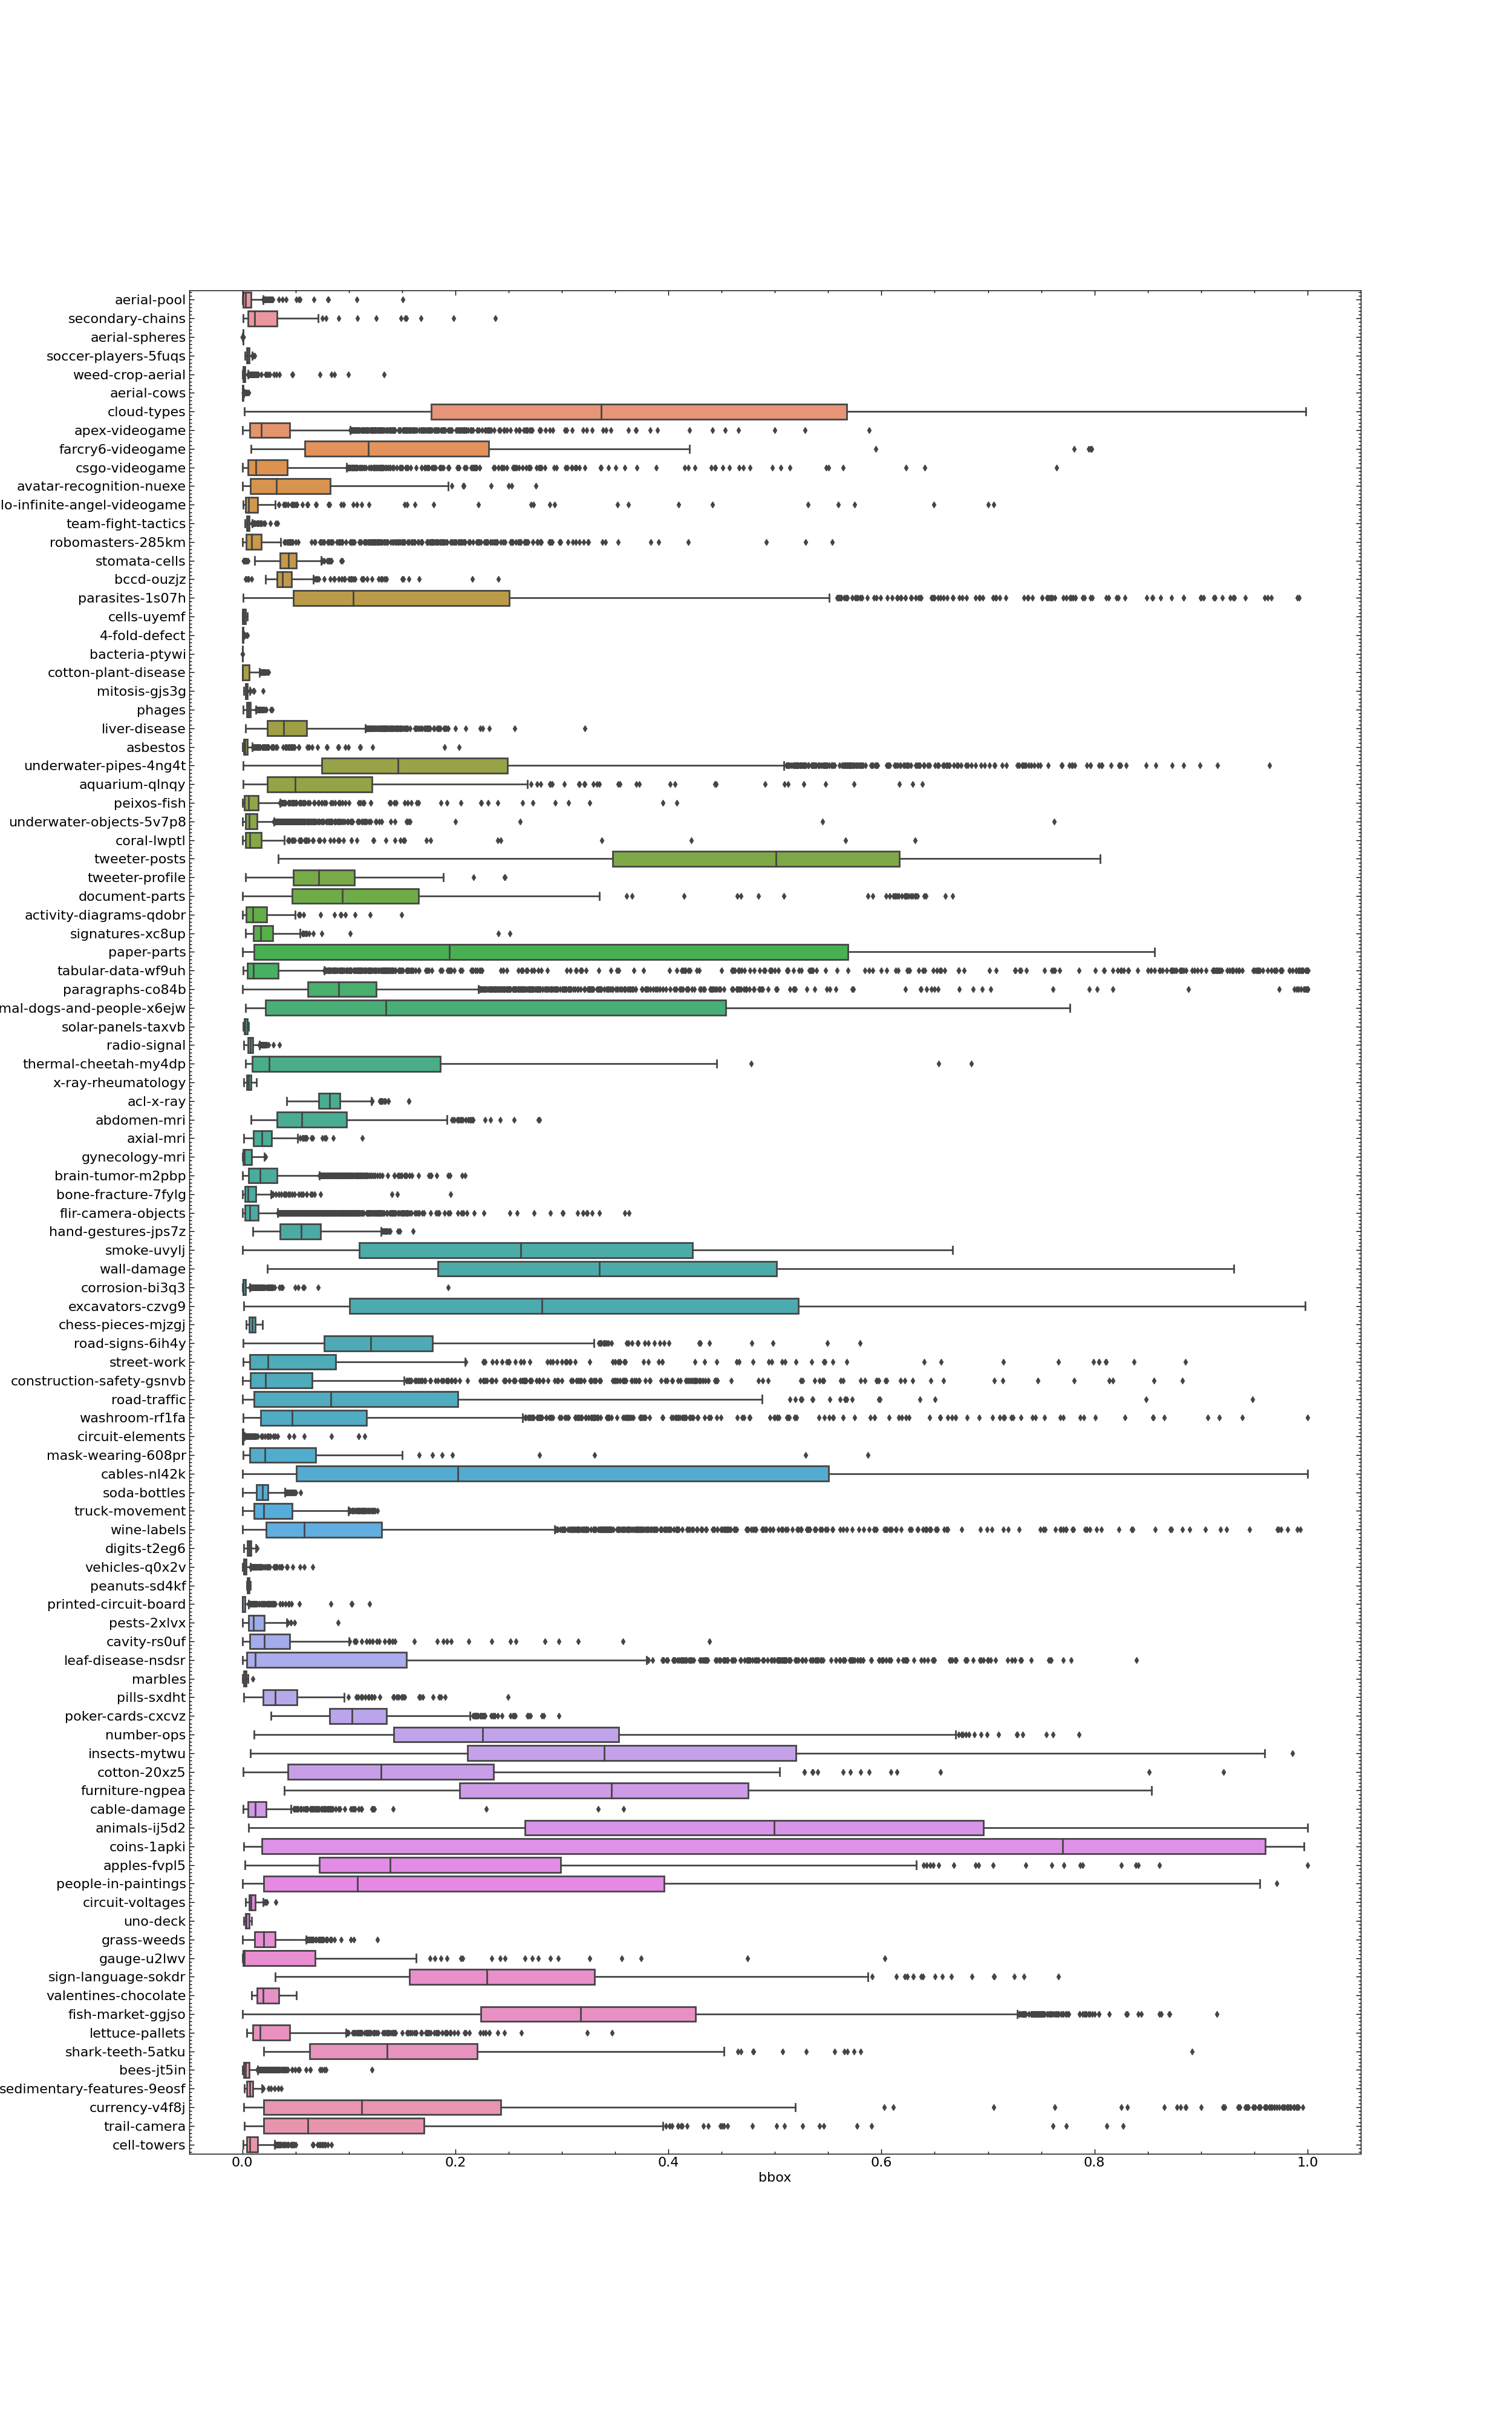

In [43]:
fig = plt.figure(figsize=(25, 40))
plot = sns.boxplot(data=df["areas"], orient='h')
plt.xlabel("bbox")
plt.ylabel("dataset")
plot.set_yticklabels(df.index)
plt.gcf().savefig("plot_all_train.png")

In [16]:
plt.gcf().savefig("plot.png")

<Figure size 432x288 with 0 Axes>

### Clip Embeddings

I have sampled 512 points per dataset and encoded them with CLIP. Let's load them, avg them and plot in 2D (after PCA). Let's do it! 

In [17]:
import clip
from typing import Callable
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
RF100_ROOT = Path("./rf100/")

class ImageDataset(Dataset):
    def __init__(self, root: Path, fmt: str = "jpg", transform: Callable = None):
        super().__init__()
        self.images_path = list(root.glob(f"**/*.{fmt}"))
        self.transform = transform or ToTensor()

    def __getitem__(self, idx: int):
        image = Image.open(self.images_path[idx]).convert("RGB")
        return self.transform(image), idx, str(self.images_path[idx])

    def __len__(self):
        return len(self.images_path)

def pca(x, k, center=True):
    if center:
        m = x.mean(0, keepdim=True)
        s = x.std(0, unbiased=False, keepdim=True)
        x -= m
        x /= s
    # why pca related to svd? https://www.cs.cmu.edu/~elaw/papers/pca.pdf chap VI
    U, S, V = torch.linalg.svd(x) 
    reduced = torch.mm(x, V[:k].T)

    return reduced

@maybe_load_from_disk(Path("./embeddings_means.pkl"))
def get_embeddings(df):
    MAX_BATCHES = 2
    model, preprocess = clip.load("ViT-B/32", device=device, jit=True)
    records = []
    for dataset in tqdm(df.index):
        ds = ImageDataset(RF100_ROOT / dataset / "train/images", transform=preprocess)
        dl = DataLoader(
            ds, batch_size=256, num_workers=8, pin_memory=True, shuffle=True
        )  # we shuffle and we sample MAX_BATCHES batches per dataset
        i = 0
        means = None
        for (x, _, _) in dl:
            with torch.no_grad():
                x = x.to("cuda")
                x = model.encode_image(x)
                means = torch.vstack((means, x.mean(0))) if means is not None else x.mean(0)
            i += 1
            if i >= MAX_BATCHES: break
        if len(means.shape) == 1: means = means.unsqueeze(0)
        
        records.append(dict(dataset=dataset, clip_mean=means.mean(0).squeeze().cpu().numpy()))
            
    return pd.DataFrame.from_records(records, index=df.index)




In [18]:
embed_df = get_embeddings(df)
embed_df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_144944/2235095781.py:48: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:594.)
  x = model.encode_image(x)


[INFO] saving to embeddings_means.pkl


,dataset,clip_mean
dataset,,
aerial-pool,aerial-pool,"[0.3062, 0.008514, -0.1127, -0.2966, 0.316, -0..."
secondary-chains,secondary-chains,"[-0.313, -0.1888, 0.3103, -0.02399, -0.1104, 0..."


In [19]:
clip_means = torch.stack([torch.from_numpy(el) for el in embed_df.clip_mean.tolist()])

In [20]:
clip_means_reduced = pca(clip_means.float(), k=2)
clip_means_reduced.shape

torch.Size([100, 2])

<IPython.core.display.Javascript object>


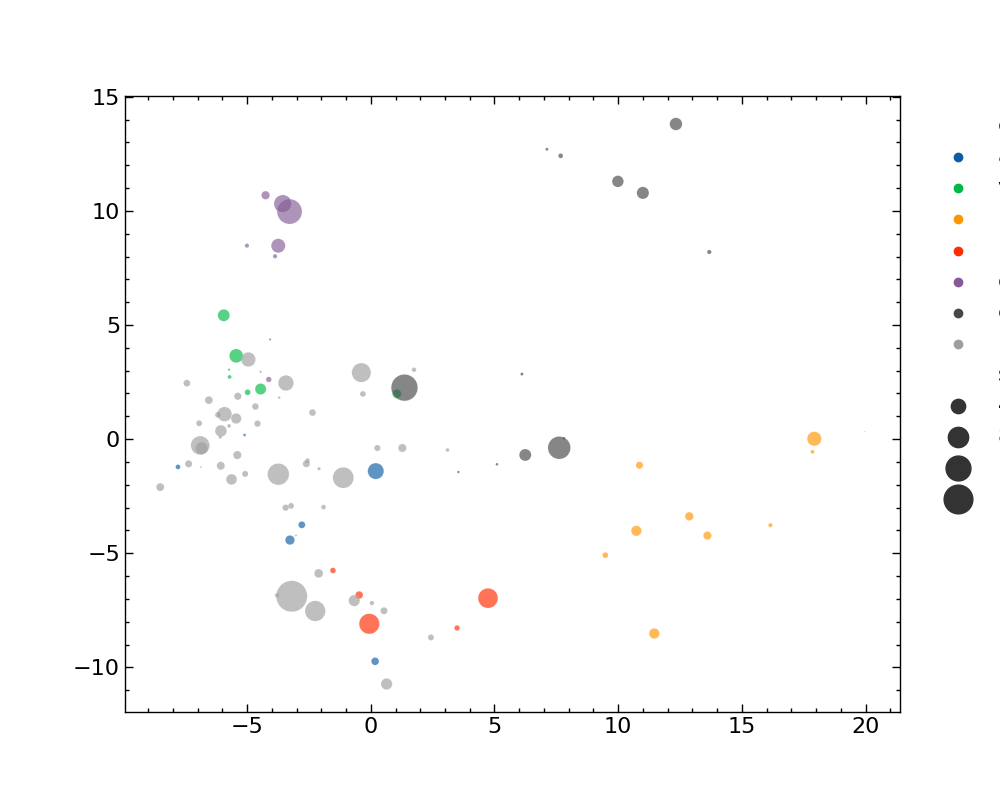

In [68]:
fig = plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x=clip_means_reduced[:,0], y=clip_means_reduced[:,1], size=df["size"], sizes=(0, 500), hue=df.category, alpha=.66, legend="brief")
sns.move_legend(ax, bbox_to_anchor=(1.02, 1), loc='upper left')

In [69]:
plt.savefig("embedds.png",)

## Plotting

In [ ]:
fig, axs = plt.subplots(2, 2,  figsize=(20,16))
# fig.suptitle('Datasets Categories')
axs[0,0].set_title("Total datasets size/category")
ax = sns.barplot(data=grouped_df, x="size", y="category", linewidth=2,  edgecolor=".2", ax=axs[0,0])
ax.set_ylabel('category')
ax.set_xlabel('size')
secax = ax.secondary_xaxis('top', functions=(lambda x: x / grouped_df["size"].sum(), lambda x:x))
secax.set_xlabel('size (%)')
ax.minorticks_on()
secax.minorticks_on()

axs[0,1].set_title("Mean datasets size/category")
ax = sns.boxplot(data=df, x="size", y="category", ax=axs[0,1])
ax.set_xlabel('size')
ax.get_yaxis().set_visible(False)
secax = ax.secondary_xaxis('size', functions=(lambda x: x / grouped_df["size"].sum(), lambda x:x))
secax.set_xlabel('size (%)')
ax.minorticks_on()
secax.minorticks_on()

axs[1,0].set_title("Mean bbox area")
ax = sns.boxplot(data=df, x="area_mean", y="category", ax=axs[1,0])
ax.set_xlabel("bbox")

axs[1,1].set_title("Mean num_classes")
ax = sns.boxplot(data=df, x="num_classes", y="category", ax=axs[1,1])
ax.set_xlabel("labels")
ax.get_yaxis().set_visible(False)


In [ ]:
plt.savefig("datasets.png")